In [1]:
import scanorama
import scanpy as sc
import scanpy.external as sce
import numpy as np
from scipy import sparse
from scipy.spatial import distance_matrix
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

In [3]:
ifname = "./data/WT/Arch1_new_aggregate_filtered_noNT.loom"

In [4]:
adata = sc.read_loom(ifname)

In [5]:
adata.X = adata.layers["norm_data"]

In [6]:
adata

AnnData object with n_obs × n_vars = 1284 × 17651
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'PigmentID', 'RNA_snn_res_0_4', 'RNA_snn_res_0_5', 'RNA_snn_res_1', 'S_Score', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'seurat_clusters'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [7]:
sc.pp.recipe_zheng17(adata, n_top_genes=2000)

In [8]:
sc.tl.pca(adata, n_comps=50)

In [9]:
sc.pp.neighbors(adata, n_neighbors=10)

In [10]:
sc.tl.diffmap(adata, n_comps=15)

In [11]:
sc.tl.louvain(adata, resolution=1.0)

In [12]:
sc.tl.paga(adata)

... storing 'ClusterName' as categorical
... storing 'Phase' as categorical
... storing 'PigmentID' as categorical
... storing 'RNA_snn_res_0_4' as categorical
... storing 'RNA_snn_res_0_5' as categorical
... storing 'RNA_snn_res_1' as categorical
... storing 'orig_ident' as categorical
... storing 'seurat_clusters' as categorical


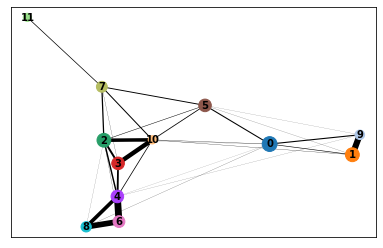

In [13]:
sc.pl.paga(adata, threshold=0.01, layout='fr', show=False)

In [14]:
adata.uns['iroot'] = np.where(adata.obs.index == "AAACCTGAGTGGCACA-1")[0][0]

In [15]:
sc.tl.dpt(adata, n_dcs = min(adata.obsm["X_diffmap"].shape[1], 10))

In [16]:
adata

AnnData object with n_obs × n_vars = 1284 × 1999
    obs: 'ClusterID', 'ClusterName', 'G2M_Score', 'Phase', 'PigmentID', 'RNA_snn_res_0_4', 'RNA_snn_res_0_5', 'RNA_snn_res_1', 'S_Score', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'seurat_clusters', 'n_counts_all', 'louvain', 'dpt_pseudotime'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors', 'iroot'
    obsm: 'pca_cell_embeddings', 'tsne_cell_embeddings', 'umap_cell_embeddings', 'X_pca', 'X_diffmap'
    varm: 'pca_feature_loadings', 'PCs'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

In [17]:
sc.tl.draw_graph(adata, init_pos='paga')

In [18]:
celltypes_cellassign = np.array( pd.read_csv("./data/cellassign/celltypes.csv", index_col=0)['x'], str )
cellprobs_cellassign = np.array( pd.read_csv("./data/cellassign/cellprobs.csv", index_col=0), float )
for i in range(len(celltypes_cellassign)):
    if celltypes_cellassign[i] == 'other':
        celltypes_cellassign[i] = 'unassigned'
adata.obs['cellassign'] = pd.Series(celltypes_cellassign, index=adata.obs_names, dtype='category')

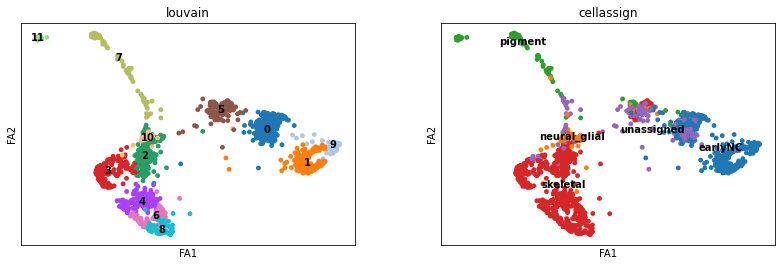

In [19]:
sc.pl.draw_graph(adata, color=['louvain', 'cellassign'], legend_loc='on data', save=False)

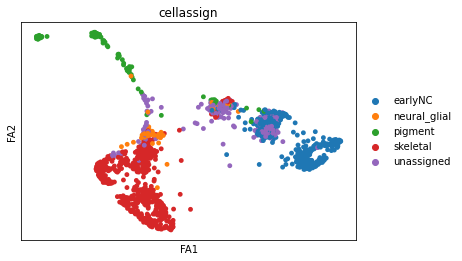

In [20]:
sc.pl.draw_graph(adata, color=['cellassign'], legend_loc='right margin', save="paga_celltype.pdf")

In [21]:
start_id = "AAACCTGAGTGGCACA-1"
adata.uns['iroot'] = np.where(adata.obs.index == start_id)[0][0]
sc.tl.dpt(adata)

In [22]:
# grouping
grouping = pd.DataFrame({"cell_id": adata.obs.index, "group_id": adata.obs.louvain})

# milestone networks
milestone_network = pd.DataFrame(
  adata.uns["paga"]["connectivities_tree"].todense(),
  index=adata.obs.louvain.cat.categories,
  columns=adata.obs.louvain.cat.categories
).stack().reset_index()
milestone_network.columns = ["from", "to", "length"]
milestone_network = milestone_network.query("length > 0").reset_index(drop=True)
milestone_network["directed"] = False

# dimred
dimred_name = "X_draw_graph_fa"
dimred = pd.DataFrame([x for x in adata.obsm[dimred_name].T]).T
dimred.columns = ["comp_" + str(i+1) for i in range(dimred.shape[1])]
dimred["cell_id"] = adata.obs.index

# branch progressions: the scaled dpt_pseudotime within every cluster
branch_progressions = adata.obs
branch_progressions["dpt_pseudotime"] = branch_progressions["dpt_pseudotime"].replace([np.inf, -np.inf], 1) # replace unreachable pseudotime with maximal pseudotime
branch_progressions["percentage"] = branch_progressions.groupby("louvain")["dpt_pseudotime"].apply(lambda x: (x-x.min())/(x.max() - x.min())).fillna(0.5)
branch_progressions["cell_id"] = adata.obs.index
branch_progressions["branch_id"] = branch_progressions["louvain"].astype(np.str)
branch_progressions = branch_progressions[["cell_id", "branch_id", "percentage"]]

# branches:
# - length = difference between max and min dpt_pseudotime within every cluster
# - directed = not yet correctly inferred
branches = adata.obs.groupby("louvain").apply(lambda x: x["dpt_pseudotime"].max() - x["dpt_pseudotime"].min()).reset_index()
branches.columns = ["branch_id", "length"]
branches["branch_id"] = branches["branch_id"].astype(np.str)
branches["directed"] = True

# branch network: determine order of from and to based on difference in average pseudotime
branch_network = milestone_network[["from", "to"]]
average_pseudotime = adata.obs.groupby("louvain")["dpt_pseudotime"].mean()
for i, (branch_from, branch_to) in enumerate(zip(branch_network["from"], branch_network["to"])):
  if average_pseudotime[branch_from] > average_pseudotime[branch_to]:
    branch_network.at[i, "to"] = branch_from
    branch_network.at[i, "from"] = branch_to

In [23]:
outdir = "./data"
branches.to_csv(outdir+"/branches.txt", index=False, header=True)
branch_progressions.to_csv(outdir+"/branch_progressions.txt", index=False, header=True)
branch_network.to_csv(outdir+"/branch_network.txt", index=False, header=True)
grouping.to_csv(outdir+"/grouping.txt", index=False, header=True)

In [24]:
adata.write("./data/adata_paga.h5ad")

... storing 'branch_id' as categorical
